In [1]:
import math
import numpy as np
import torch as t
import torch.nn as nn

In [2]:
dtype = t.float
t.cuda.set_device(0)
device = t.device("cuda:0")

## Starting with numpy

In [12]:
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# randomly initialise some weights
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-6

In [4]:
for o in range(2000):
    # forward pass: compute pred y
    y_pred = a + b * x + c * x**2 + d * x**3
    
    # loss
    loss = np.square(y_pred - y).sum()
    if o % 100 == 99:
        print(o, loss)
    
    # backprop to compute gradients for a,b,c,d wrt. loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x**2).sum()
    grad_d = (grad_y_pred * x**3).sum()
    
    # update weights
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d
    
print(f'result: y = {a} + {b}x + {c}x^2 + {d} x^3')

99 263.05063044524894
199 179.98025058243832
299 124.15998788458273
399 86.61700999405716
499 61.3446000140089
599 44.31681596740624
699 32.83329018532896
799 25.08136263764211
899 19.843275597945002
999 16.300244924789336
1099 13.901266677321326
1199 12.275208111148126
1299 11.171858827511347
1399 10.422371262772785
1499 9.912691818674288
1599 9.565701958069432
1699 9.329203615877637
1799 9.1678292082011
1899 9.057589272794145
1999 8.982194312016006
result: y = -0.010165809456063452 + 0.8484472513997057x + 0.0017537712909704599x^2 + -0.09215069784619286 x^3


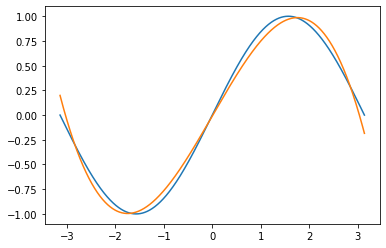

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

y_pred = a + b*x + c*x**2 + d*x**3

ax.plot(x,y)
ax.plot(x,y_pred)

## using autograd

In [13]:
x = t.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = t.sin(x)
y = y.to('cuda:0')

a = t.randn((), device=device, dtype=dtype, requires_grad=True)
b = t.randn((), device=device, dtype=dtype, requires_grad=True)
c = t.randn((), device=device, dtype=dtype, requires_grad=True)
d = t.randn((), device=device, dtype=dtype, requires_grad=True)

for i in range(2000):
    y_pred = a + b * x + c * x**2 + d * x**3
    
    loss = (y_pred - y).pow(2).sum()
    
    if i % 100 == 99:
        print(i, loss.item())
    
    """
    using autograd to compute the backward pass
    this will compute gradient loss wrt all tensors with requires_grad=True
    after this, a.grad, b.grad ... will be tensors holding the gradient of the loss wrt. a,b ... respectively
    """
    
    loss.backward()
    
    # update the weights without tracking it with requires_grad=True
    
    with t.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad        
        c -= learning_rate * c.grad        
        d -= learning_rate * d.grad        
        
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'result: y = {a} + {b}x + {c}x^2 + {d} x^3')

RuntimeError: CUDA error: an illegal memory access was encountered

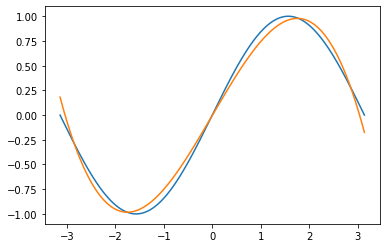

In [7]:
y_pred = a + b*x + c*x**2 + d*x**3

fig, ax = plt.subplots()
ax.plot(x.cpu(),y.cpu())
ax.plot(x.cpu(),y_pred.detach().cpu())

In [8]:
# Defining custom autograd functions

class Poly3(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # ctx is context object in which you can stash info for backwards path
        ctx.save_for_backward(input)
        return 0.5 * (5 * input**3 - 3 * input)
    
    @staticmethod
    def backward(ctx, grad_output):
        # load input from context
        input = ctx.saved_tensors
        return grad_oputput * 1.5 *(5 * input**2 - 1)

In [10]:
# For this example the output is a linear function of (x, x^2, x^3) so we can consider it a linear layer neural network
p = t.tensor([1,2,3], device=device)
xx = x.unsqueeze(-1).pow(p)

xx
model = nn.Sequential(
    nn.Linear(3,1),
    nn.Flatten(0,1)
)

loss_fn = nn.MSELoss(reduction="sum")

for i in range(2000):
    y_pred = model(xx)
    y_pred = y_pred.to('cuda:0')
    
    loss = loss_fn(y_pred, y)
    
    model.zero_grad()
    
    loss.backward()
    
    with t.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

linear_layer = model[0]

RuntimeError: CUDA error: an illegal memory access was encountered